# Initializing Libraries

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import timeit
import warnings

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, LearningCurveDisplay, cross_validate, cross_val_score, ValidationCurveDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler , OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    f1_score, 
    precision_score, 
    recall_score, 
    ConfusionMatrixDisplay, 
    roc_curve, 
    auc,
    homogeneity_score, 
    completeness_score, 
    v_measure_score,
    adjusted_rand_score, 
    adjusted_mutual_info_score, 
    silhouette_score
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn.feature_variance import VarianceThreshold


from scipy.spatial.distance import cdist
from scipy.stats import skew
from scipy.spatial.distance import hamming

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

import itertools
import timeit
import time

from sklearn.metrics.pairwise import pairwise_distances

#Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, f1_score, homogeneity_score, pairwise_distances_argmin_min
from sklearn.mixture import GaussianMixture as EM
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA

In [3]:
from ucimlrepo import fetch_ucirepo 

In [4]:
def gtid():
    return  903952938

In [5]:
np.random.seed=gtid()

# Loading and Analysing Dataset

## Dataset 1 - Diabetes Prediction

In [6]:
def load_dataset_1(test_size=0.3, random_state=gtid()):
        cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
        X = cdc_diabetes_health_indicators.data.features
        y = cdc_diabetes_health_indicators.data.targets
        temp  = X.copy()
        temp['Diabetes'] = y
        temp.drop_duplicates(inplace = True)
        X,y = temp[[i for i in temp.columns if i!='Diabetes']], temp[['Diabetes']]
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, random_state=random_state)
        return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = load_dataset_1()

In [6]:
# Get unique values for each column
unique_values = {col: X_train[col].unique() for col in X_train.columns}

# Display unique values
for col, values in unique_values.items():
    print(f"Unique values in column '{col}': {values}")

Unique values in column 'HighBP': [1 0]
Unique values in column 'HighChol': [0 1]
Unique values in column 'CholCheck': [1 0]
Unique values in column 'BMI': [31 21 34 27 25 24 40 20 38 29 36 32 26 18 22 23 28 30 37 39 19 35 48 60
 49 33 51 44 45 42 43 47 56 14 15 54 13 87 41 50 63 46 16 17 53 57 92 55
 72 69 84 75 71 67 52 68 81 77 79 62 64 58 82 12 89 61 65 80 73 95 70 59
 66 98 74 85 90 76 88 83]
Unique values in column 'Smoker': [0 1]
Unique values in column 'Stroke': [0 1]
Unique values in column 'HeartDiseaseorAttack': [0 1]
Unique values in column 'PhysActivity': [0 1]
Unique values in column 'Fruits': [0 1]
Unique values in column 'Veggies': [0 1]
Unique values in column 'HvyAlcoholConsump': [0 1]
Unique values in column 'AnyHealthcare': [1 0]
Unique values in column 'NoDocbcCost': [0 1]
Unique values in column 'GenHlth': [3 1 2 5 4]
Unique values in column 'MentHlth': [ 0  2 30  1 15  3  5 10 20 26  4  7  8 25 14 28 12  6 21 27 22 16 29  9
 18 19 17 23 24 11 13]
Unique values in

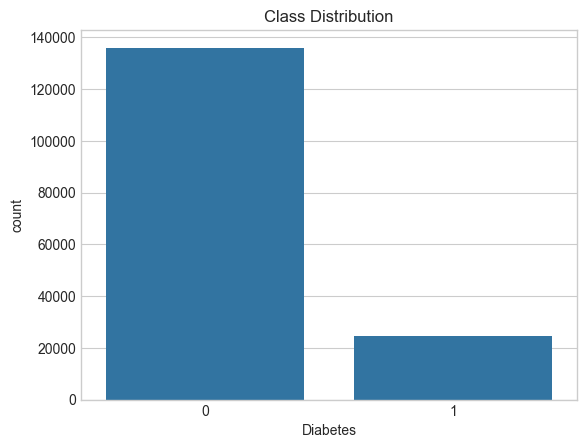

In [7]:
sns.countplot(x=y_train.Diabetes)
plt.title('Class Distribution')
plt.show()

In [8]:
X_train.shape, X_test.shape

((160631, 21), (68843, 21))

~This Dataset contains 21 attributes, 2 decision classes, 160K training samples and 68K test samples.
> HighBP, HighChol, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, DiffWalk, Sex: These features (14) are binary, indicating presence (1) or absence (0) of a condition or behavior.

> GenHlth, Education, Income, Age: These features (4) have multiple distinct values

> BMI, MentHlth, PhysHlth: These (3) are High Cardinality features


~ k-means assumes that clusters are spherical and equally sized, which might not always be the case.

    - Since k-means relies on distance measures, binary features might not be well-suited unless properly preprocessed (e.g., using one-hot encoding or calculating the appropriate distance metric like Hamming distance).
    
    - Cluster : Diabetes=0 is much larger than Diabetes=1, k-means might poorly partition the data.

    -  EM can handle binary features if they are considered as Bernoulli distributions.

Althought its a binary classification problem, it will be interesting to see if clusters find more classes - risk to diabetes 


1. PCA

    Output: PCA transforms the data into a new space defined by the principal components, capturing the most variance in the data.
    
    Mitigation: Normalize the data to ensure each feature contributes equally to the variance calculation.

2. ICA

    Output: ICA identifies components that maximize statistical independence.   
    
    Mitigation: Center and whiten the data to make it more suitable for ICA.

3. Randomized Projections (RP):

    Output: RP reduces the dimensionality of the data, often with lower computational cost than PCA.
    
    Mitigation: Run multiple projections to ensure stability and robustness of the results.

Class Balancing: https://www.linkedin.com/pulse/addressing-class-imbalance-health-data-using-python-salam-sukurat-/

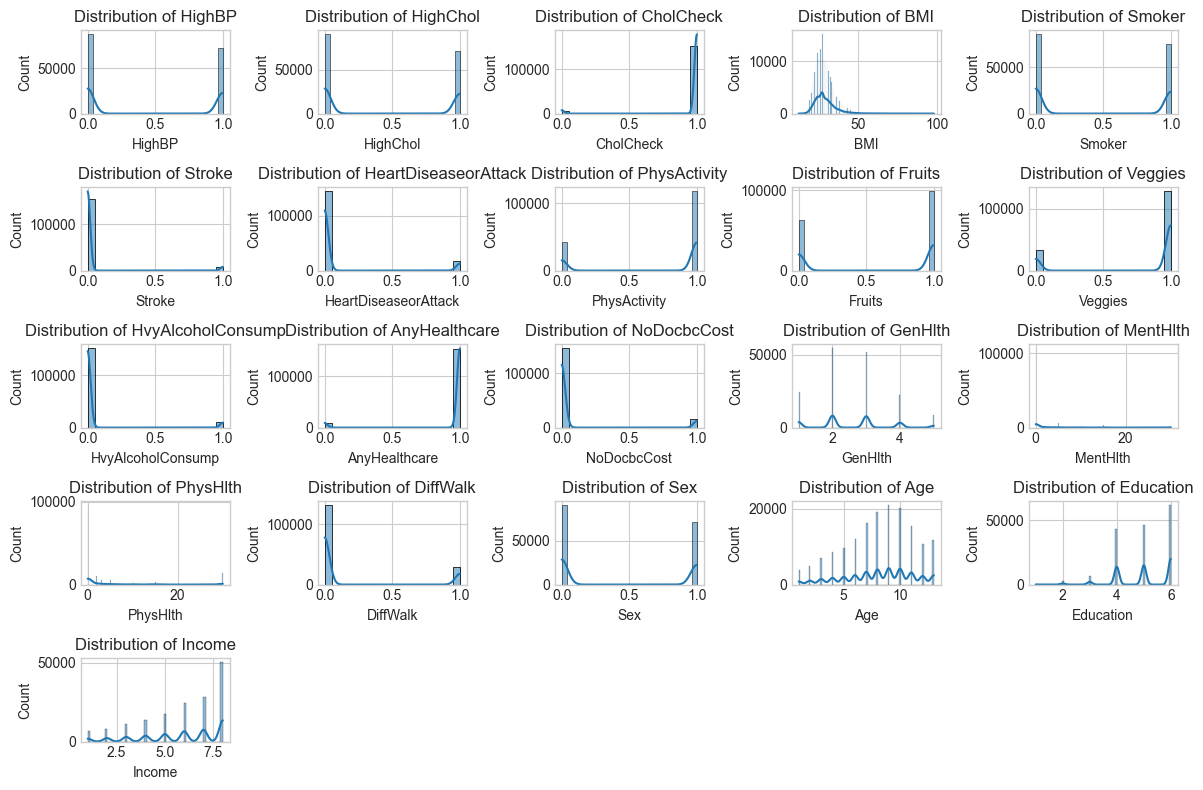

In [43]:
# Visualizing distributions
plt.figure(figsize=(12, 8))
for i, column in enumerate(X_train.columns, 1):
    plt.subplot(5, 5, i)
    sns.histplot(X_train[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

In [9]:
df = X_train.copy()
df['Diabetes'] = y_train


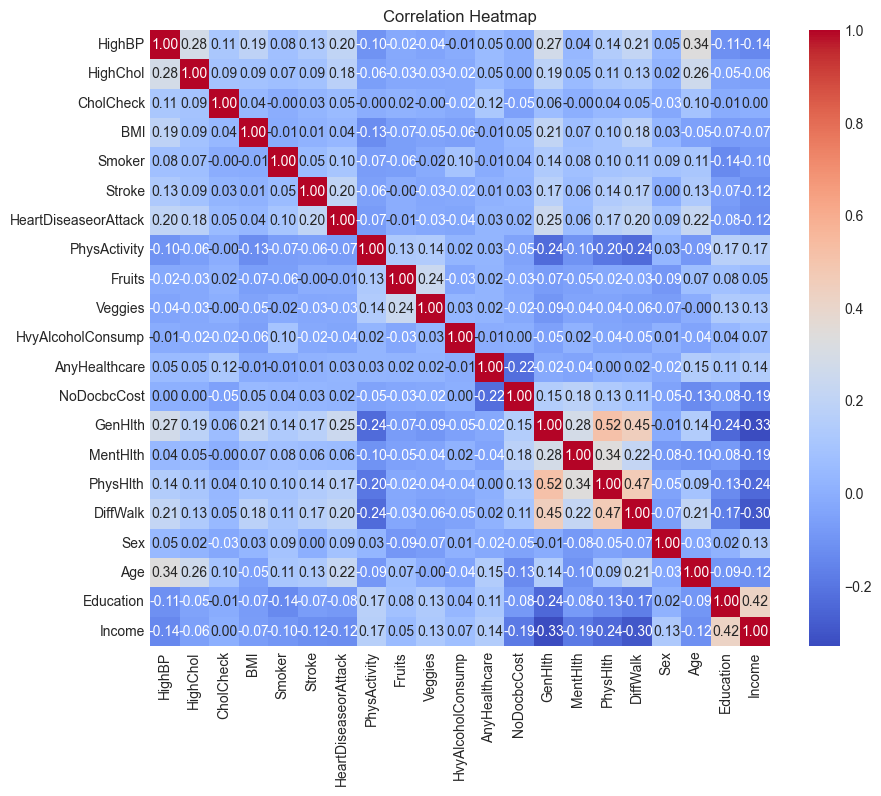

In [10]:
# Compute the correlation matrix
correlation_matrix = X_train.corr()
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"size": 10})

# Add title
plt.title('Correlation Heatmap')

# Show plot
plt.show()

In [10]:
def identify_outliers(df):
    """
    Identifies features with outliers in a DataFrame using the IQR method.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    
    Returns:
    list: A list of features that contain outliers.
    """
    outliers_features = []
    
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.1)
        Q3 = df[column].quantile(0.9)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        if ((df[column] < lower_bound) | (df[column] > upper_bound)).any():
            outliers_features.append(column)
    
    return outliers_features

# Example usage:
# df = pd.read_csv('your_dataset.csv')
outlier_features = identify_outliers(X_train)
print("Features with outliers:", outlier_features)


Features with outliers: ['CholCheck', 'BMI', 'Stroke', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost']


It Is also intersting to see outliers and uneven attribute class distribbution for many of the attributes - it will be intersting to see how the performance increases with robust transformation

In [11]:
def hopkins_statistic(X, sample_size=None):
    if sample_size is None:
        sample_size = min(10, X.shape[0] // 10)
    rng = np.random.default_rng()
    X_sample = X[rng.choice(X.shape[0], sample_size, replace=False)]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    u_distances, _ = nbrs.kneighbors(rng.uniform(np.min(X, axis=0), np.max(X, axis=0), (sample_size, X.shape[1])))
    w_distances, _ = nbrs.kneighbors(X_sample)
    H = np.sum(u_distances) / (np.sum(u_distances) + np.sum(w_distances))
    return H

# Example usage:
X = X_train.to_numpy()  # Convert DataFrame to NumPy array
hopkins = hopkins_statistic(X)
print(f"Hopkins statistic: {hopkins}")

Hopkins statistic: 1.0


gap statistic: https://core.ac.uk/download/pdf/12172514.pdf

https://ieeexplore.ieee.org/document/6009578


The computational complexity of the algorithm is generally linear with regard to the number of instances m, the number of clusters k, and the number of dimensions n. However, this is only true when the data has a clustering structure. If it does not, then in the worst-case scenario the complexity can increase exponentially with the number of instances. In practice, this rarely happens, and k-means is generally one of the fastest clustering algorithms.


Understanding the Limitations
Binary and Ordinal Data: Binary and ordinal data can naturally form distinct clusters due to the limited number of unique values. This can lead to a high Hopkins statistic, indicating clustering tendency even if the clusters may not be meaningful for your specific classification task.
Cluster Meaningfulness: The presence of clusters in the data doesn't automatically imply that these clusters correspond to the classes of interest (e.g., diabetes vs. non-diabetes). Clusters might group data based on other features or noise rather than the target variable.

## Getting the right clusters

### On non processed Data

In [49]:
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it has been preprocessed
# Save DataFrame to a memmap file
def save_to_memmap(df, filename='data_memmap.dat'):
    # Save DataFrame to a binary file in a memory-mapped format
    np_array = df.to_numpy()
    memmap_array = np.memmap(filename, dtype=np.float64, mode='w+', shape=np_array.shape)
    memmap_array[:] = np_array[:]
    del memmap_array  # Flush to disk

# Load DataFrame from a memmap file
def load_memmap(filename='data_memmap.dat', shape=None):
    return np.memmap(filename, dtype=np.float64, mode='r', shape=shape)

# Function to calculate silhouette score for a given number of clusters
def silhouette_score_kmeans(memmap_array, n_clusters):
    mbkmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000)
    cluster_labels = mbkmeans.fit_predict(memmap_array)
    return silhouette_score(memmap_array, cluster_labels)

def train_kmeans(memmap_array, n_clusters):
    mbkmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000)
    labels = mbkmeans.fit_predict(memmap_array)
    return labels, mbkmeans.inertia_

# Function to plot silhouette scores for a range of cluster numbers
def plot_silhouette_scores_optimized(memmap_array, shape):
    range_n_clusters = range(2, 10)
    silhouette_avg = Parallel(n_jobs=-1)(delayed(silhouette_score_kmeans)(memmap_array, n_clusters) for n_clusters in range_n_clusters)

    plt.figure(figsize=(8, 6))
    plt.plot(range_n_clusters, silhouette_avg, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Average Silhouette Score')
    plt.title('Silhouette Analysis showing the optimal number of clusters')
    plt.show()

# Function to apply PCA and then calculate silhouette scores
def plot_silhouette_scores_with_pca(memmap_array, shape, n_components=10):
    pca = PCA(n_components=n_components, random_state=42)
    X_reduced = pca.fit_transform(memmap_array)
    
    range_n_clusters = range(2, 10)
    silhouette_avg = Parallel(n_jobs=-1)(delayed(silhouette_score_kmeans)(X_reduced, n_clusters) for n_clusters in range_n_clusters)

    plt.figure(figsize=(8, 6))
    plt.plot(range_n_clusters, silhouette_avg, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Average Silhouette Score')
    plt.title('Silhouette Analysis with PCA showing the optimal number of clusters')
    plt.show()

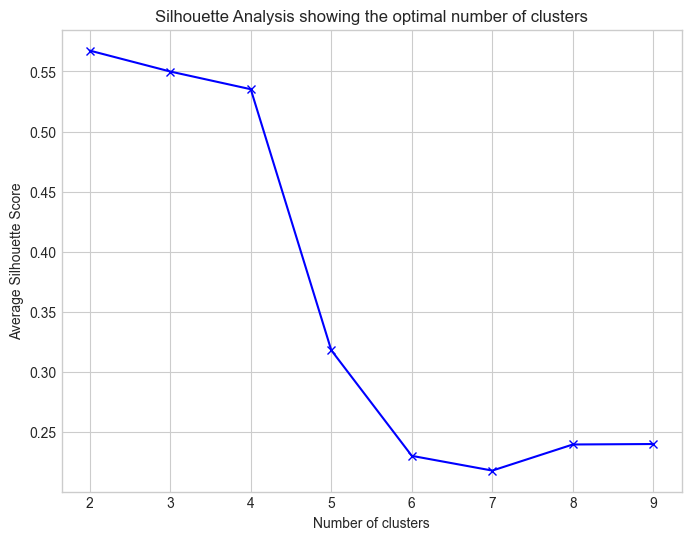

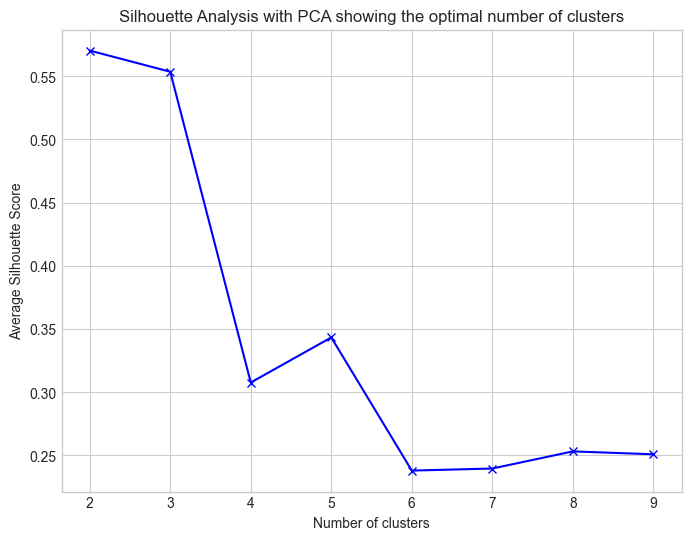

In [10]:


# Example usage:
filename = 'data_memmap.dat'
shape = X_train.shape
save_to_memmap(X_train, filename)
memmap_array = load_memmap(filename, shape)

# Plot silhouette scores directly on the memory-mapped array
plot_silhouette_scores_optimized(memmap_array, shape)

# Or with PCA reduction
plot_silhouette_scores_with_pca(memmap_array, shape)


In [13]:
def preprocess_data1(X,random_state=42):
    """
    Preprocess the data by one-hot encoding non-binary categorical features, applying SMOTE, and scaling using RobustScaler.
    
    Parameters:
    X (pd.DataFrame): Feature DataFrame.
    y (pd.Series or np.array): Target labels.
    random_state (int): Random state for reproducibility.

    Returns:
    pd.DataFrame: Preprocessed feature DataFrame.
    np.array: Preprocessed target labels.
    """
    categorical_features = []
    
    # Identify categorical and numerical features
    for col in X.columns:
        if X[col].dtype == 'object' or len(X[col].unique()) < 10:  # Assuming categorical if less than 10 unique values
            categorical_features.append(col)
    
    # Remove binary features from numerical features list
    numerical_features = [col for col in X.columns if col not in categorical_features]

    # Define the preprocessor for the pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', RobustScaler(), numerical_features)
        ]
    )
    
    # Apply the preprocessor to X
    X_preprocessed = preprocessor.fit_transform(X)

    # Get feature names after transformation
    ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = list(ohe_feature_names) + numerical_features
    
    # Convert the transformed data back to a DataFrame
    X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names)
    
    return X_preprocessed_df

### On Processed Data

In [15]:
x = preprocess_data1(X_train)

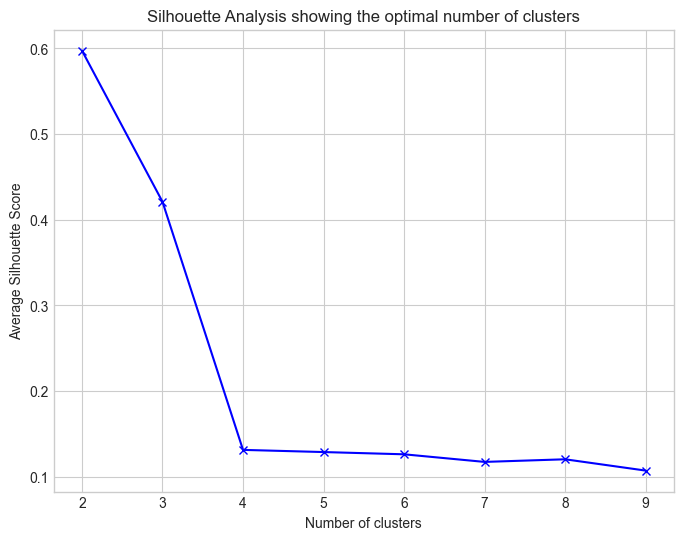

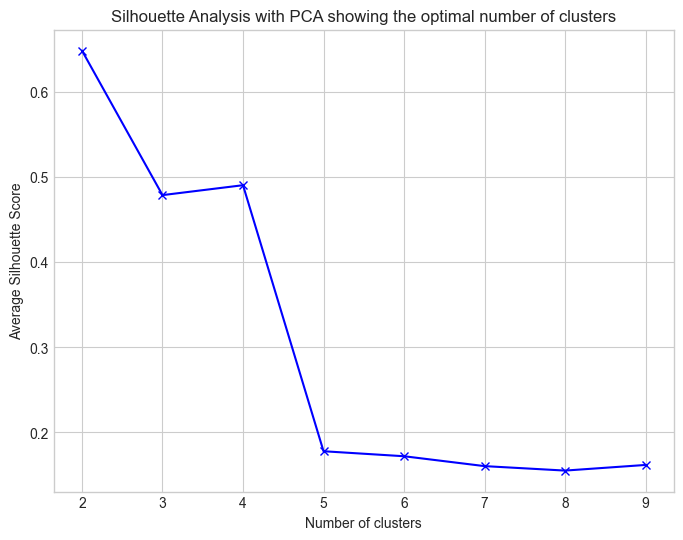

In [12]:

filename = 'data_memmap2.dat'
shape = x.shape
save_to_memmap(x, filename)
memmap_array = load_memmap(filename, shape)

# Plot silhouette scores directly on the memory-mapped array
plot_silhouette_scores_optimized(memmap_array, shape)

# Or with PCA reduction
plot_silhouette_scores_with_pca(memmap_array, shape)

What makes this dataset interesting?

In brief, a clustering system is binary if and only if each cluster is generated by two elements. It is strongly binary if and only if a smallest cluster containing a subset S of X is generated by two elements of S. Obviously, a strongly binary clustering system is binary.

A classic algorithm for binary data clustering is Bernoulli Mixture model. The model can be fit using Bayesian methods and can be fit also using EM (Expectation Maximization).

https://www.researchgate.net/publication/2872930_Clustering_Binary_Data_Streams_with_K-means

**Challenges with K-Means for Binary Data**

    -Distance Metric:K-Means uses Euclidean distance, which reduces to the number of variables on which two binary cases disagree. This is not a robust measure for binary data, as it does not capture the structure or relationships within the data effectively.

    -Initial Centers and Symmetry:The initial centers are chosen randomly, and due to the nature of binary data, many cases will be equidistant from multiple centers. This leads to arbitrary cluster assignments, especially in the early iterations.

    -Cluster Centers: After the first iteration, cluster centers are updated to be the mean of the points in the cluster, which for binary data is the proportion of ones. This can result in non-integer values, but the initial arbitrary assignments can persist through iterations, leading to unstable and often meaningless clusters.

In [31]:
seed=gtid()

In [45]:
# Define function to calculate centroid stability using stratified sampling
def calculate_centroid_stability(X_train, sample_sizes, n_clusters=2):
    full_kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    full_kmeans.fit(X_train)
    full_centroids = full_kmeans.cluster_centers_

    stability_scores = []

    for sample_size in sample_sizes:
        distances = []
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        for train_index, _ in skf.split(X_train, np.zeros(len(X_train))):  # StratifiedKFold with dummy y
            X_sample = X_train[train_index][:sample_size]
            kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
            kmeans.fit(X_sample)
            sample_centroids = kmeans.cluster_centers_

            # Calculate average distance to full centroids
            distance = np.mean(np.min(cdist(sample_centroids, full_centroids, 'euclidean'), axis=1))
            distances.append(distance)

        # Average distance for current sample size
        stability_score = np.mean(distances)
        stability_scores.append(stability_score)

    return stability_scores

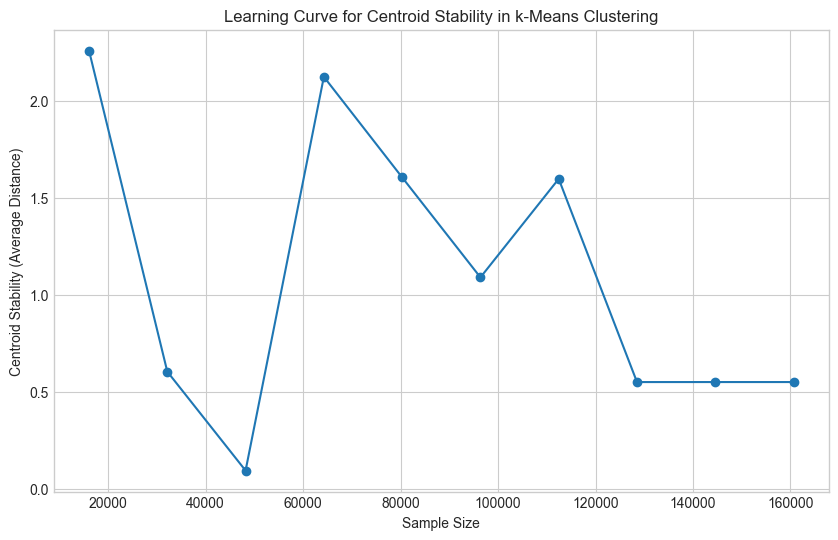

In [47]:
# Define sample sizes and calculate centroid stability
sample_sizes = np.linspace(0.1, 1.0, 10) * len(X_train)
sample_sizes = sample_sizes.astype(int)
stability_scores2 = calculate_centroid_stability(X_train.to_numpy(), sample_sizes)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, stability_scores2, marker='o')
plt.xlabel('Sample Size')
plt.ylabel('Centroid Stability (Average Distance)')
plt.title('Learning Curve for Centroid Stability in k-Means Clustering')
plt.grid(True)
plt.show()

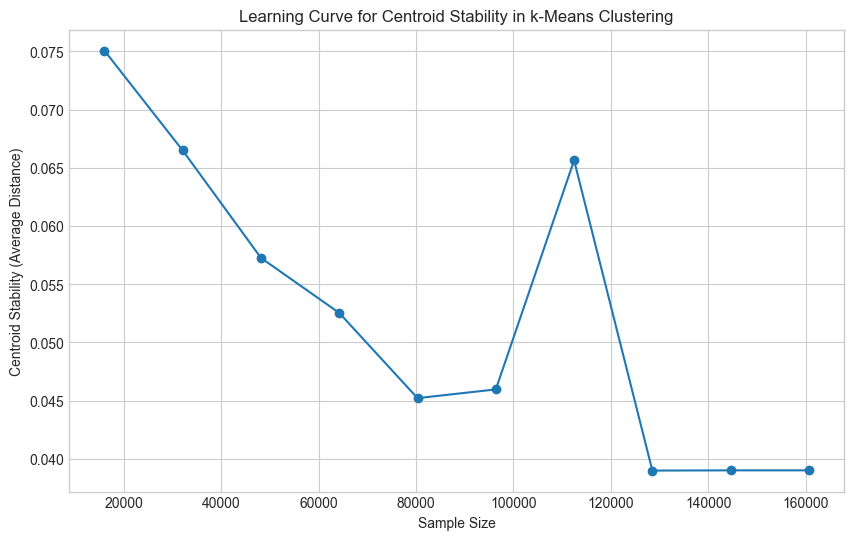

In [43]:
# Define sample sizes and calculate centroid stability
sample_sizes = np.linspace(0.1, 1.0, 10) * len(x)
sample_sizes = sample_sizes.astype(int)
stability_scores1 = calculate_centroid_stability(x.to_numpy(), sample_sizes)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, stability_scores1, marker='o')
plt.xlabel('Sample Size')
plt.ylabel('Centroid Stability (Average Distance)')
plt.title('Learning Curve for Centroid Stability in k-Means Clustering')
plt.grid(True)
plt.show()

outliers affected centroid stability. But preprocessing helped normalizing data for the outliers.
Will class balancing help futher?

In [50]:
stability_scores2[-1], stability_scores1[-1]

(0.5513332167018945, 0.03901576486991757, 0.009598675820596609)

euclidean distance can be sensitive to the high dimensionality and sparsity introduced by one-hot encoding. We want to try hamming distance. But also K "means" is not meaningful for binaryu data
when robustness to outliers is needed, and when non-Euclidean distance measures are more appropriate - K-Medoids (PAM - Partitioning Around Medoids)
specially when Clustering biological data where robustness to outliers (e.g., measurement errors) is crucial.

In [17]:
x.head()

,HighBP_0,HighBP_1,HighChol_0,HighChol_1,CholCheck_0,CholCheck_1,Smoker_0,Smoker_1,Stroke_0,Stroke_1,...,Income_3,Income_4,Income_5,Income_6,Income_7,Income_8,BMI,MentHlth,PhysHlth,Age
0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.500,0.0,2.50,0.00
1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-0.750,0.0,0.25,-1.50
2,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.875,0.0,0.00,0.50
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.000,1.0,0.25,-0.50
4,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.250,0.0,1.25,1.25


In [18]:

filename = 'data_memmap2.dat'
shape = x.shape
save_to_memmap(x, filename)
memmap_array = load_memmap(filename, shape)

In [ ]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

In [44]:
def evaluate_k_means(n, X_test, y_test):
    metrics = {}
    start_time = time.time()
    kmeans = kmeans(n_clusters=n, random_state=42)
    elapsed_time = time.time() - start_time
    test_labels = kmeans.predict(X_test)
    
    # Calculate metrics
    metrics['Clusters'] = i
    metrics['Time (sec)'] = elapsed_time
    metrics['Homogeneity Score'] = homogeneity_score(y_test, test_labels)
    metrics['Completeness Score'] = completeness_score(y_test, test_labels)
    metrics['V-Measure Score'] = v_measure_score(y_test, test_labels)
    metrics['Adjusted Rand Score'] = adjusted_rand_score(y_train, test_labels)
    metrics['Adjusted Mutual Information Score'] = adjusted_mutual_info_score(y_test, test_labels)
    metrics['Silhouette Score'] = silhouette_score(y_test, test_labels, metric='euclidean')
    metrics['Accuracy Score'] = accuracy_score(y_test, test_labels)
    metrics['Sum of Squared Distances'] = kmeans.inertia_

    return pd.DataFrame([metrics])

In [50]:
# KMeans clustering and metrics calculation
def kmeans_metrics(memmap_array, y_train):
    all_metrics=[]
    for i in range(2, 10):
        print(i)
        metrics={}
        start_time = time.time()
        train_labels, inertia = train_kmeans(memmap_array, i)
        elapsed_time = time.time() - start_time
        
        # Predict and get labels
        # train_labels = kmeans.predict(X_train)
        # test_labels = kmeans.predict(X_test)
        
        # Calculate metrics
        metrics['Clusters'] = i
        metrics['Time (sec)'] = elapsed_time
        metrics['Silhouette Score'] = silhouette_score(X_train, train_labels, metric='euclidean')
        metrics['Sum of Squared Distances'] = inertia
        metrics['Variance Ratio Criterion'] = calinski_harabasz_score(X_train, train_labels)
        metrics['Davies-Bouldin Index'] = davies_bouldin_score(X_train, train_labels)
        all_metrics.append(metrics)
    return pd.DataFrame(all_metrics)
    

In [51]:
df = kmeans_metrics(memmap_array, y_train['Diabetes'].values)

2


In [ ]:
df.to_csv('Kmeans_dataset_1.csv', index=False)